# **1. Predicting Student's Grade Class**

In [1]:
# Import necessary functions
# Data Wrangling
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
# from catboost import CatBoostClassifier

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Suppress Python warnings
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Suppress warnings from XGBoost and LightGBM (C++ backend)
import os
os.environ["XGBOOST_ENABLE_WARNINGS"] = "0"
os.environ["LIGHTGBM_VERBOSE"] = "0"

In [2]:
# !pip install lightgbm

In [3]:
# !pip install catboost

## Load Data

In [4]:
df = pd.read_csv('data/student_data.csv')
df.head()

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0


In [5]:
df.columns = df.columns.str.lower()

## **1. Predicting Student GradeClass**
Develop a predictive model to estimate student grades based on various demographic, academic, and personal features.

## Defining appropriate X and y
To start out, we'll consider y to be the target variable (gradeclass) and everything else to be X excluding `studentid` since it's a artifact and not a feature

In [6]:
y = df["gradeclass"]
X = df.drop(columns=["gradeclass", "studentid"], axis=1)

## Train-Test Split
Specifying a random_state means that we will get consistent results even if the kernel is restarted

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

## Preprocessing

### Dealing with Categorical Variables

- Binary Categorical Variables: 
  - `Gender, Tutoring, Extracurricular, Sports, Music, Volunteering`
    - These are already binary (0 or 1). No further encoding needed.
- Ordinal Variables:
  - `ParentalSupport`:
    - Since this has an inherent order, we can keep it as is (0 to 4). Machine learning models will handle this naturally
- Norminal Variables:
  - `Ethnicity, ParentalEducation`:
    - These have no inherent order, so we'll use One-Hot Encoding to avoid assigning artificial ordinal relationships.

In [8]:
# Identifying categorical features
binary_features = ['gender', 'tutoring', 'extracurricular', 'sports', 'music', 'volunteering']
ordinal_features = ['parentalsupport','parentaleducation']
nominal_features = ['ethnicity']

# Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(drop='first'), nominal_features),
        ('scale', StandardScaler(), ['studytimeweekly', 'absences', 'gpa'])
    ],
    remainder='passthrough' # Keep other features (e.g., binary and ordinal) as is
)
#Create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])
# Fit and transform on X_train, transform X_test
X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)
#-----------------------------------------Prev code commented out------------------------------------
# # One-Hot Encoding for nominal features
# X_nominal_encoded = pd.get_dummies(X_train[nominal_features], drop_first=True)  # drop_first to avoid multicollinearity

# # Combine the encoded features with the rest of the dataset
# X_train_preprocessed = pd.concat([X_train.drop(nominal_features, axis=1), X_nominal_encoded], axis=1)

In [9]:
# Inspect shape on sets
print(X_train_transformed.shape)
print(X_test_transformed.shape)
# both X_train_transformed and X_test_transformed have the same number of columns (19 in this case),
# representing the features used for training and testing. This ensures that the model can process both 
# datasets seamlessly.

(1794, 15)
(598, 15)


**Side Note:** *Features like `Absences` or `StudyTimeWeekly` have extreme values (e.g., some students with 30 absences or 20 study hours), `StandardScaler` would handle these better by reducing the impact of outliers.*
*On the other hand, if all numeric features have consistent ranges and no outliers, `MinMaxScaler` might be simpler and equally effective.*

### Normalization (Scaling)
Now let's look at the numeric features. This time we'll also pay more attention to the meaning of the features, and only include relevant ones (e.g. not including `studentid` because this is a data artifact, not a true feature).

Another important data preparation practice is to normalize your data. That is, if the features are on different scales, some features may impact the model more heavily than others. To level the playing field, we often normalize all features to a consistent scale of 0 to 1.

As you can see, our features are currently not on a consistent scale:

## Feature Selection
Since some features might not conntribute significantly to our models' performance, or they might introduce noise altogether, we'll go ahead and remove irrelevant features to potentially reduce overfitting and improve interpretability

In [10]:
# Retrieve feature names from the ColumnTransformer or pipeline
feature_names = preprocessor.get_feature_names_out()

In [11]:
# Convert X_train_transformed to a pandas DataFrame
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=feature_names)

# Check the DataFrame
X_train_transformed_df.head()

,onehot__ethnicity_1,onehot__ethnicity_2,onehot__ethnicity_3,scale__studytimeweekly,scale__absences,scale__gpa,remainder__age,remainder__gender,remainder__parentaleducation,remainder__tutoring,remainder__parentalsupport,remainder__extracurricular,remainder__sports,remainder__music,remainder__volunteering
0,0.0,1.0,0.0,-0.659514,0.286082,-0.088261,16.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,-1.033486,1.230391,-1.524547,18.0,1.0,3.0,0.0,2.0,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,-1.129705,-1.248419,0.672644,15.0,0.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0
3,0.0,0.0,0.0,0.610018,0.994314,-0.922379,15.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.207836,-1.720574,1.809182,15.0,0.0,2.0,0.0,3.0,1.0,0.0,1.0,0.0


In [12]:
# Select numeric features from the DataFrame
numeric_features = X_train_transformed_df.select_dtypes(include=['float64', 'int64']).columns

a. Correlation Analysis (For Numeric Features)

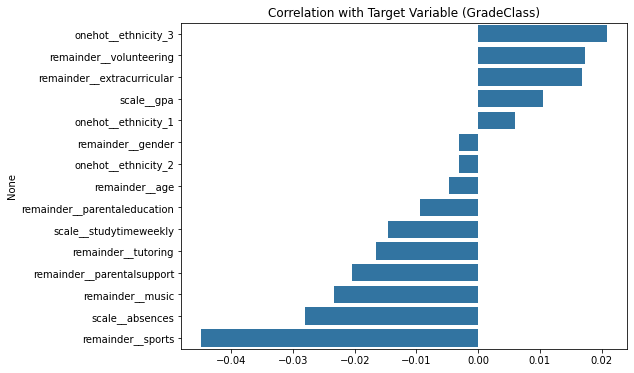

In [13]:
# Correlation with the target variable
corr_matrix = X_train_transformed_df[numeric_features].corrwith(pd.Series(y_train))

corr_matrix = corr_matrix.sort_values(ascending=False)
plt.figure(figsize=(8, 6))
sns.barplot(x=corr_matrix.values, y=corr_matrix.index)
plt.title('Correlation with Target Variable (GradeClass)')
plt.show()

b. Mutual Information (ForCategorical Features)

## Modeling

Model 1: **Baseline Model - Random Forest**

In [14]:
# Initialize the model
rf_baseline = RandomForestClassifier(class_weight='balanced', random_state=42)

# Fit the model to the training data
rf_baseline.fit(X_train_transformed, y_train)

# Predict on the test set
y_pred = rf_baseline.predict(X_test_transformed)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9130434782608695
Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.55      0.67        31
         1.0       0.94      0.89      0.91        65
         2.0       0.89      0.90      0.90        90
         3.0       0.88      0.86      0.87       112
         4.0       0.93      0.98      0.95       300

    accuracy                           0.91       598
   macro avg       0.90      0.84      0.86       598
weighted avg       0.91      0.91      0.91       598



In [15]:
# Feature importance
importances = rf_baseline.feature_importances_
feature_importances_df = pd.DataFrame(
    {'Feature': X_train_transformed_df.columns, 'Importance': importances}
).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importances_df)

Feature Importances:
                         Feature  Importance
5                     scale__gpa    0.433554
4                scale__absences    0.198420
3         scale__studytimeweekly    0.101865
10    remainder__parentalsupport    0.050445
8   remainder__parentaleducation    0.039977
6                 remainder__age    0.038139
9            remainder__tutoring    0.020164
7              remainder__gender    0.018895
11    remainder__extracurricular    0.018195
12             remainder__sports    0.017059
1            onehot__ethnicity_2    0.016681
13              remainder__music    0.012747
14       remainder__volunteering    0.012541
0            onehot__ethnicity_1    0.012026
2            onehot__ethnicity_3    0.009293


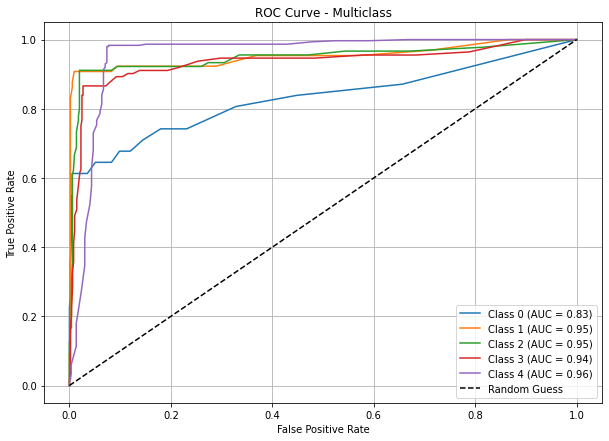

Macro AUC-ROC: 0.92
Weighted AUC-ROC: 0.94


In [16]:
# Binarize the output (needed for multiclass ROC)
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3, 4])  # GradeClass classes
n_classes = y_test_binarized.shape[1]

# Get predicted probabilities
y_pred_proba = rf_baseline.predict_proba(X_test_transformed)

# Initialize variables for plotting
fpr = {}
tpr = {}
roc_auc = {}

# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

# Add diagonal line for reference (random model)
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")

# Configure plot
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Multiclass")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Compute Overall AUC-ROC (macro and weighted)
macro_roc_auc = roc_auc_score(y_test_binarized, y_pred_proba, multi_class="ovr", average="macro")
weighted_roc_auc = roc_auc_score(y_test_binarized, y_pred_proba, multi_class="ovr", average="weighted")

print(f"Macro AUC-ROC: {macro_roc_auc:.2f}")
print(f"Weighted AUC-ROC: {weighted_roc_auc:.2f}")

**Metrics**
- Class-Specific AUC-ROC: Shows how well the model distinguishes a specific class from all others.
- Macro AUC-ROC: Averages AUC across all classes equally, giving each class the same importance.
- Weighted AUC-ROC: Averages AUC across all classes but weights by the number of samples in each class, reflecting the class distribution.

**Interpretation**
- *Class-Specific AUC Scores:*
Each class has an AUC score of 0.83 or higher, which indicates that the model performs fairly well in distinguishing each class from the others.
AUC values close to 1.0 mean the model is highly effective at separating the positive class from the negative classes for all thresholds.
Macro and Weighted AUC-ROC:

- *Macro AUC-ROC (0.92):*
This is the average of the AUC scores across all classes, treating all classes equally.
A score of 0.92 confirms that the model has consistently high performance across all classes.

- *Weighted AUC-ROC (0.94):*
This takes the class imbalance into account by weighting the AUC of each class based on its proportion in the dataset.
Since this value is also high, it indicates that the model performs well even for the minority classes (e.g., Class 0).

- *ROC Curve:*
The curves are very close to the top-left corner, which signifies high true positive rates and low false positive rates for all classes.

From the observed results, our baseline model performs faily well overall. We'll look into how other models perform for the purposes of comparison.

Additional Models 

Accuracy: 0.9163879598662207
Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.61      0.73        31
         1.0       0.98      0.89      0.94        65
         2.0       0.88      0.91      0.90        90
         3.0       0.88      0.85      0.86       112
         4.0       0.93      0.98      0.95       300

    accuracy                           0.92       598
   macro avg       0.92      0.85      0.88       598
weighted avg       0.92      0.92      0.91       598



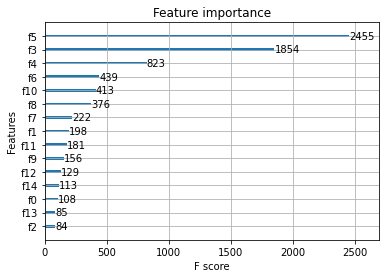

In [17]:
# Initialize the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, class_weight='balanced', eval_metric='mlogloss', verbosity=0, random_state=42)

# Fit the model to the training data
xgb_model.fit(X_train_transformed, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test_transformed)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Feature importance plot
xgb.plot_importance(xgb_model)
plt.show()

Overall, XGBoost appears to perform slightly better than our baseline model. Let's go ahead and inspect other models to see how well they perform

**Additional Models - Pipeline**

In [18]:
# Define feature groups
binary_features = ['gender', 'tutoring', 'extracurricular', 'sports', 'music', 'volunteering']
ordinal_features = ['parentalsupport', 'parentaleducation']  # Assuming ordinal features are left unchanged
nominal_features = ['ethnicity']
numeric_features = ['studytimeweekly', 'absences', 'gpa']

# Column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(drop='first'), nominal_features),  # One-hot encode nominal features
        ('scale', StandardScaler(), numeric_features)  # Scale numeric features
    ],
    remainder='passthrough'  # Keep binary and ordinal features unchanged
)

# Models to evaluate
models = {
    "Random Forest": RandomForestClassifier(class_weight="balanced", random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, verbosity=0, eval_metric="mlogloss", random_state=42), #verbosity=0: Suppress all warnings
    "Logistic Regression": LogisticRegression(class_weight="balanced", random_state=42, max_iter=1000),
    "SVM (RBF Kernel)": SVC(kernel="rbf", class_weight="balanced", probability=True, random_state=42),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(class_weight="balanced", random_state=42),
    "Naive Bayes": GaussianNB(),
    "LightGBM": LGBMClassifier(class_weight="balanced", random_state=42, force_row_wise=True, verbose=-1), #verbosity=-1 suppress all LightGBM warnings
    # Add other models here if needed
}

# Store results
results = []

for model_name, model in models.items():
    # Create pipeline for each model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),  # Use the defined preprocessor
        ('classifier', model)  # Add the model
    ])
    
    # Cross-validate model
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring="accuracy")
    mean_score = np.mean(scores)
    std_dev = np.std(scores)
    
    # Append results to a list
    results.append({"Model": model_name, "Accuracy Mean": mean_score, "Accuracy Std Dev": std_dev})

# Convert results to a DataFrame for easy comparison
results_df = pd.DataFrame(results)
print("\n=== Model Comparison ===")
print(results_df)

# Evaluate the best pipeline on the test set
best_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight="balanced", random_state=42))
])
best_pipeline.fit(X_train, y_train)

# Test set evaluation
y_pred = best_pipeline.predict(X_test)
print("\nBest Pipeline Test Set Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")


=== Model Comparison ===
                 Model  Accuracy Mean  Accuracy Std Dev
0        Random Forest       0.920288          0.009275
1              XGBoost       0.928092          0.004489
2  Logistic Regression       0.632096          0.012554
3     SVM (RBF Kernel)       0.664996          0.012587
4                  KNN       0.691202          0.009924
5        Decision Tree       0.851173          0.030484
6          Naive Bayes       0.773131          0.010083
7             LightGBM       0.925305          0.003294

Best Pipeline Test Set Performance:
Accuracy: 0.9130
Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.55      0.67        31
         1.0       0.94      0.89      0.91        65
         2.0       0.89      0.90      0.90        90
         3.0       0.88      0.86      0.87       112
         4.0       0.93      0.98      0.95       300

    accuracy                           0.91       598
   macro avg 

Looking at the results, **XGBoost** emerges as the top-performing model based on **accuracy mean (92.81%)** with a reasonable **Accuracy Std Dev (0.4%)**, closely followed by **Random Forest** and **LightGBM**. RF and LGBM are very close in performance and are generally more robust to overfitting than a single Decision Tree which is not far off also making them better choices since we're prioritizing generalization.

There's an observed performance gap with other models: Logistic Regression, KNN, SVM, and Naive Bayes which appear to perform significantly worse in this case, indicating that our dataset and target variable likely exhibit nonlinear patterns that simpler models struggle to capture.

### Evaluating Top Models Performance

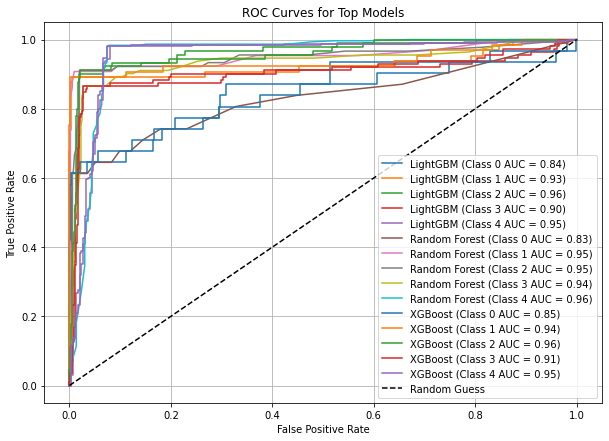

           Model   AUC-ROC  F1-Score  Accuracy
0       LightGBM  0.916214  0.869254  0.911371
1  Random Forest  0.924360  0.859681  0.913043
2        XGBoost  0.921130  0.875813  0.916388


In [19]:
# Select the top models
top_models = [
    ('LightGBM', LGBMClassifier(class_weight="balanced", random_state=42, force_row_wise=True, verbose=-1)),
    ('Random Forest', RandomForestClassifier(random_state=42, class_weight='balanced')),
    ('XGBoost', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
]

# Initialize a DataFrame to store results
comparison_results = []

# Plot ROC curves
plt.figure(figsize=(10, 7))

for name, model in top_models:
    # Fit the model
    model.fit(X_train_transformed, y_train)
    
    # Predict probabilities
    y_pred_prob = model.predict_proba(X_test_transformed)
    
    # Calculate metrics
    auc_roc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='macro')
    f1 = classification_report(y_test, model.predict(X_test_transformed), output_dict=True)['macro avg']['f1-score']
    accuracy = model.score(X_test_transformed, y_test)
    
    # Add results to the comparison table
    comparison_results.append({'Model': name, 'AUC-ROC': auc_roc, 'F1-Score': f1, 'Accuracy': accuracy})
    
    # Plot ROC curve for each class
    for i in range(y_pred_prob.shape[1]):  # Loop through classes
        fpr, tpr, _ = roc_curve(y_test == i, y_pred_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (Class {i} AUC = {roc_auc:.2f})')

# Plot configuration
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curves for Top Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

# Display comparison table
comparison_df = pd.DataFrame(comparison_results)
print(comparison_df)

**AUC-ROC:**
Random Forest has the highest overall AUC-ROC (0.924), indicating the best ability to separate classes across all thresholds.
XGBoost is close behind with an AUC-ROC of 0.921.
LightGBM has the lowest AUC-ROC of the three at 0.916 but is still strong.

**F1-Score:**
XGBoost leads slightly with an F1-score of 0.876, which indicates better precision-recall balance compared to the others.
LightGBM is close behind at 0.869, while Random Forest lags slightly at 0.860.

**Accuracy:**
XGBoost achieves the highest accuracy (91.6%), though Random Forest and LightGBM are very close.

**ROC Curve:**
The plot shows XGBoost and Random Forest performing almost perfectly for some classes (e.g., Class 2 and Class 4).
Decision Tree lags for Class 0 but performs comparably for other classes.


### Confusion Matrix Evaluation
Let's try to understand our models at a granular level by getting insights into:
- Which classes are being misclassified
- Whether errors are biased toward specific classes

In [20]:
# Fit the top models on the entire training dataset
models['Random Forest'].fit(X_train_transformed, y_train)
models['XGBoost'].fit(X_train_transformed, y_train)
models['LightGBM'].fit(X_train_transformed, y_train)

LGBMClassifier(class_weight='balanced', force_row_wise=True, random_state=42,
               verbose=-1)

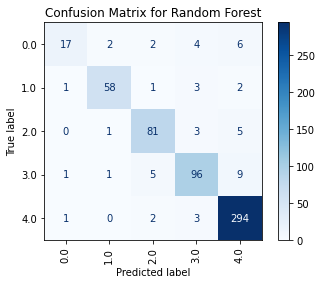

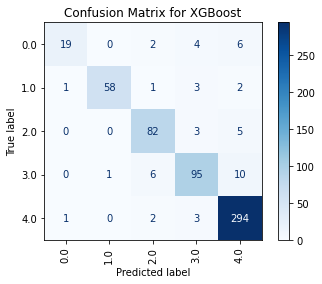

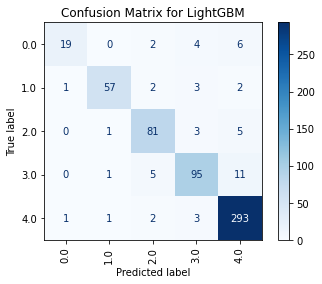

In [21]:
# Function to plot confusion matrix
def plot_confusion_matrix(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='Blues', xticks_rotation='vertical')
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

# Plot confusion matrices for the fitted models
plot_confusion_matrix(models['Random Forest'], X_test_transformed, y_test, "Random Forest")
plot_confusion_matrix(models['XGBoost'], X_test_transformed, y_test, "XGBoost")
plot_confusion_matrix(models['LightGBM'], X_test_transformed, y_test, "LightGBM")

Overall, the three models show decent performance. Let's try and implement ensemble learning to see whether the three models combined have better performance than the individual models.

### Ensemble Learning

=== Voting Classifier Results ===
Accuracy: 0.9181
AUC-ROC: 0.9240

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.61      0.73        31
         1.0       0.98      0.89      0.94        65
         2.0       0.89      0.91      0.90        90
         3.0       0.88      0.86      0.87       112
         4.0       0.93      0.98      0.95       300

    accuracy                           0.92       598
   macro avg       0.92      0.85      0.88       598
weighted avg       0.92      0.92      0.92       598



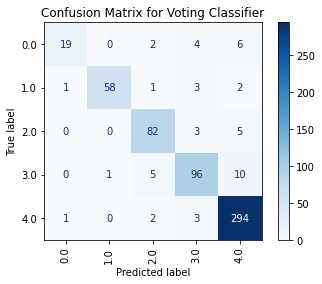

In [22]:
# Define voting classifier
voting_clf = VotingClassifier(
    estimators=[
        ('xgb', models['XGBoost']),
        ('rf', models['Random Forest']),
        ('lgbm', models['LightGBM'])
    ],
    voting='soft', # 'soft' for probabilities, 'hard' for majority voting
)
# Fit classifier
voting_clf.fit(X_train_transformed, y_train)

# Make predictions on test set
y_pred_voting = voting_clf.predict(X_test_transformed)

# Evaluate the voting classifier
accuracy = accuracy_score(y_test, y_pred_voting)
roc_auc = roc_auc_score(y_test, voting_clf.predict_proba(X_test_transformed), multi_class='ovr')
report = classification_report(y_test, y_pred_voting)

# Display the results
print("=== Voting Classifier Results ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")
print("\nClassification Report:")
print(report)

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_voting)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=voting_clf.classes_)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix for Voting Classifier")
plt.show()

### Ensemble Feature Importance

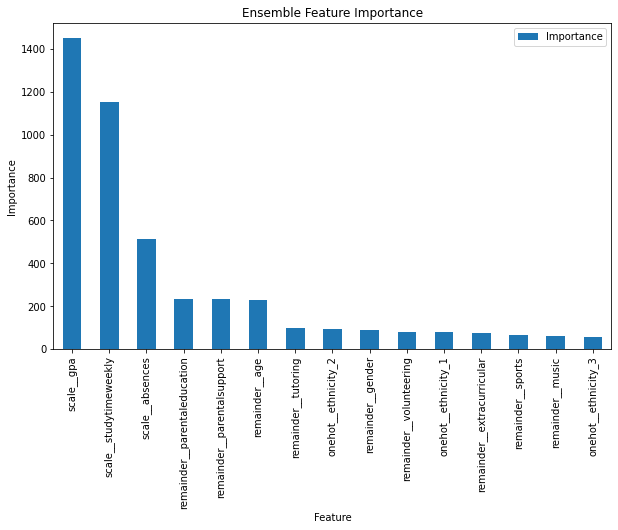

In [23]:
# Feature Importance for Random Forest
rf_importances = models['Random Forest'].feature_importances_

# Feature Importance for LightGBM
lgbm_importances = models['LightGBM'].feature_importances_

# Feature Importance for XGBoost
xgb_importances = models['XGBoost'].feature_importances_

# Combine into a DataFrame for easier visualization
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
ensemble_importance = (
    0.4 * xgb_importances + 0.3 * rf_importances + 0.3 * lgbm_importances  # Adjust weights as needed
)

ensemble_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': ensemble_importance
}).sort_values(by='Importance', ascending=False)

# Plot ensemble feature importance
ensemble_importance_df.set_index('Feature').plot(kind='bar', figsize=(10, 6), title="Ensemble Feature Importance")
plt.ylabel("Importance")
plt.show()